### Generating noise from a PSD

We want to generate a noise series, $n(t)$, that has a particular power spectrum, $S_n(f)$. The frequency domain representation of the noise, $\tilde{n}(f)$, is related to the PSD by

$$ \langle \tilde{n}^*(f) \tilde{n}(f') \rangle = \delta(f-f') \frac{1}{2} S_n(f) $$

(if the noise is stationary, the different Fourier components are uncorrelated, and so the ensemble average of the Fourier components of the noise has this form). For $f=f'$, the right-hand side diverges due to the delta function. However, in any real experiment we have a finite value of the time $T$ used to measure $\tilde{n}(f)$. So, restricting the time interval to $-T/2 < t < T/2$ we have

$$ \delta(f=0) \rightarrow \left[ \int_{-T/2}^{T/2} \mathrm{d}t ~ e^{-2\pi ift} \right]_{f=0} = T. $$

Then, with $f=f'$ we get

$$ \langle |\tilde{n}(f)|^2 \rangle = \frac{1}{2} S_n(f)T. $$

Note, the factor $1/2$ is conventionally inserted so that $\langle n^2(t) \rangle$ is obtained by integrating $S_n(f)$ over the phsyical range $0 \leq f < \infty$, rather than from $-\infty$ to $\infty$. 

We can easily generate a noise series $\tilde{n}'(f)$ that has the property $\langle |\tilde{n}'(f)|^2 \rangle = 1$ using a normal distribution. The idea is to then scale this noise series appropriately such that it satisfies $\langle |\tilde{n}(f)|^2 \rangle = \frac{1}{2} S_n(f)T$, and then perform a inverse Fourier transform to get the noise in the time domain:

$$ n(t) = \int_{-\infty}^{\infty} \mathrm{d}f ~ \tilde{n}(f) ~ e^{2\pi ift}. $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch
from ringdown import interferometer

import corner

We will work with the amplitude specral density (ASD) throughout, which is simply the square root of the PSD $\sqrt{S_n(f)}$. In particular, we use the O4 target ASD for Hanford:

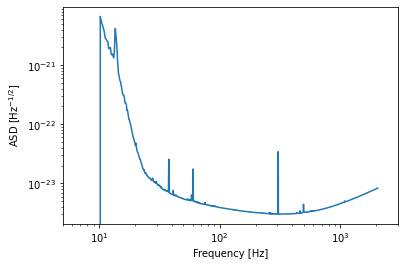

In [2]:
# Create example time and frequency arrays
fs = 4096
dt = 1/fs
times = np.arange(-512, 512, dt)
freqs = np.fft.rfftfreq(len(times), d=dt)

# Load in the O4 target ASD
H1 = interferometer('H1')
asd_func = H1.asd('O4')
asd = asd_func(freqs)

# Plot
plt.figure()
plt.loglog(freqs, asd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD $[\mathrm{Hz}^{-1/2}]$')
plt.xlim(5,3000)
plt.show()

We generate our noise series, $\tilde{n}'(f)$ (which satisfies $\langle |\tilde{n}'(f)|^2 \rangle = 1$), in the following way:

In [3]:
# Create two arrays of normal samples
noise_prime_real = np.random.normal(size=len(asd))
noise_prime_imag = np.random.normal(size=len(asd))

# Combine the arrays to create the complex series, and normalise
noise_prime = (noise_prime_real + 1j*noise_prime_imag)/np.sqrt(2)

# The mean of the magnitude squared of this noise is unity
print('Mean squared magnitude =',np.mean(abs(noise_prime)**2))

Mean squared magnitude = 1.0005993049892794


We want the noise to satisfy $\langle |\tilde{n}(f)|^2 \rangle = \frac{1}{2} S_n(f)T$. To ensure this we scale by $\sqrt{\frac{1}{2} S_n(f) T}$, i.e. we define

$$ \tilde{n}(f) = \sqrt{\frac{1}{2} S_n(f) T} ~ \tilde{n}'(f). $$

Our noise in the time domain is then given by

$$ n(t) = \int_{-\infty}^{\infty} \mathrm{d}f ~ \sqrt{\frac{1}{2} S_n(f) T} ~ \tilde{n}'(f) ~ e^{2\pi ift}. $$

When we discretize this becomes

$$ n_m = \sum_{k=0}^{N-1} \Delta f \sqrt{\frac{1}{2} S_n(f_k) T} ~ \tilde{n}'_k ~ e^{2\pi i \frac{mk}{N}}, \qquad m=0,\,\dots,\,N-1 $$

where $\Delta f = 1/T$ is the frequency resolution, and $N$ is the number of data points in the time $T$.

The NumPy FFT function, https://numpy.org/doc/stable/reference/routines.fft.html, has a $1/\sqrt{N}$ factor out the front of the inverse FFT (when `norm='ortho'` is used). So, we multiply by $\sqrt{N}$ to remove this. We can then tidy all the constants as follows

$$ \sqrt{N} \Delta f \sqrt{\frac{1}{2} T} = \sqrt{N} \frac{1}{T} \sqrt{\frac{1}{2} T} = \sqrt{\frac{N}{2T}} = \frac{1}{\sqrt{2 \Delta t}} $$

where $\Delta t$ is the time resolution.

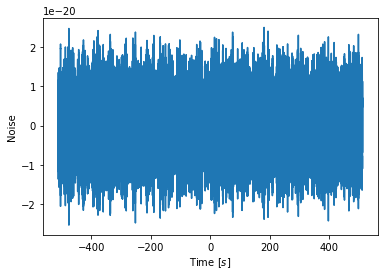

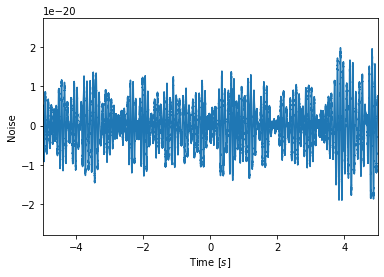

In [4]:
# Putting this all together, our time domain noise is given by
noise = (1/np.sqrt(2*dt))*np.fft.irfft(asd*noise_prime, norm='ortho')

# Plot
plt.figure()
plt.plot(times, noise)
plt.xlabel('Time $[s]$')
plt.ylabel('Noise')
plt.show()

plt.figure()
plt.plot(times, noise)
plt.xlabel('Time $[s]$')
plt.ylabel('Noise')
plt.xlim(-5,5)
plt.show()

We can recover the original ASD using Welch's method:

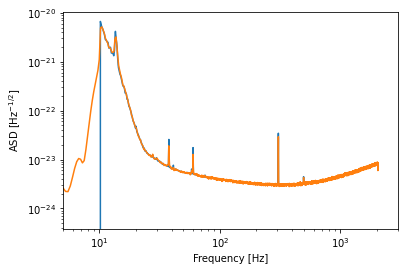

In [5]:
freqs_est, psd_est = welch(
    noise, fs=fs, window=('tukey', 0.25), nperseg=4*fs, 
    noverlap=2*fs)
 
plt.figure()
plt.loglog(freqs, asd)
plt.loglog(freqs_est, np.sqrt(psd_est))
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD $[\mathrm{Hz}^{-1/2}]$')
plt.xlim(5,3000)
plt.show()

### Measuring properties of the generated noise

By creating multiple instances of the noise in the frequency domain, $\tilde{n}(f)$, we can look at a particular frequency bin (say, $f = 200$ Hz) and measure the mean of the magnitude squared to see if it satisfies $\langle |\tilde{n}(f)|^2 \rangle = \frac{1}{2} S_n(f)T$.

In [6]:
# The frequency bin to measure the mean squared magnitude
f = 200

# The index of the chosen frequency bin
index = np.argmin((freqs-f)**2)

# The value of the ASD at the chosen frequency
asd_f = asd[index]

# We then expect the mean of the magnitude squared to be
print('Expected mean squared magnitude at',f,'Hz =',(1/2)*asd_f**2*len(times)*dt)

Expected mean squared magnitude at 200 Hz = 5.2675822796954556e-45


In [7]:
# List to store the values of the noise instances at the chosen frequency
instances = []

# Create new nosie instances with a loop and store results to the above list
for i in range(500):

    # Create two arrays of normal samples
    noise_prime_real = np.random.normal(size=len(asd))
    noise_prime_imag = np.random.normal(size=len(asd))

    # Combine the arrays to create the complex series, and normalise
    noise_prime = (noise_prime_real + 1j*noise_prime_imag)/np.sqrt(2)

    # Scale
    noise = np.sqrt(1/2)*np.sqrt(len(times)*dt)*asd*noise_prime
    
    # Store the frequency bin of interest to the list
    instances.append(noise[index])
    
# Convert to an array
instances = np.array(instances)

# The recovered mean of the squared magnitudes
print('Recovered mean squared magnitude =',np.mean(abs(instances)**2))

Recovered mean squared magnitude = 5.290220610191211e-45


We can also look at the individual distributions of the real and imagianry parts of $\tilde{n}(f) = \tilde{n}_r(f) + i\tilde{n}_i(f)$. From the expression for the mean of the magnitude squared we can write

$$ \langle |\tilde{n}(f)|^2 \rangle = \langle \tilde{n}_r^2(f) + \tilde{n}_i^2(f) \rangle = \langle \tilde{n}_r^2(f) \rangle + \langle \tilde{n}_i^2(f) \rangle = \frac{1}{2} S_n(f)T. $$

With the assumption $\langle \tilde{n}_r^2(f) \rangle = \langle \tilde{n}_i^2(f) \rangle$ (as shown above, the real and and imaginary distributions are both generated from a normal distribution, and scaled by the same amount), we then have

$$ \langle \tilde{n}_r^2(f) \rangle = \langle \tilde{n}_i^2(f) \rangle = \frac{1}{4} S_n(f)T. $$

As $\langle \tilde{n}_r(f) \rangle = \langle \tilde{n}_i(f) \rangle = 0$, then $\langle \tilde{n}_r^2(f) \rangle$ and $\langle \tilde{n}_i^2(f) \rangle$ are equal to the variance of the normal distributions that they follow. Below we plot these distributions.

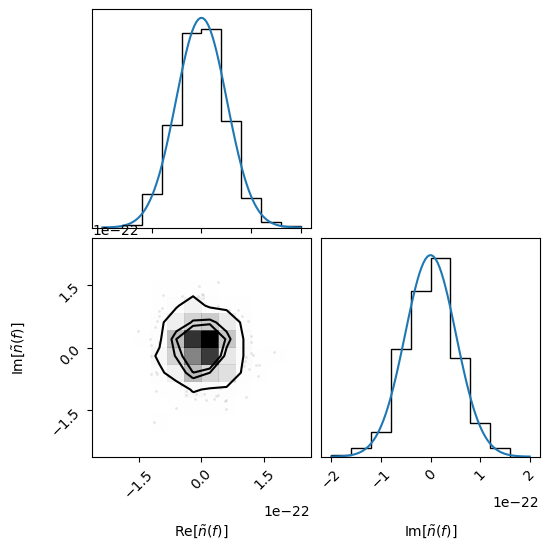

In [8]:
# Create figure
fig, axs = plt.subplots(2, 2, figsize=(6,6), dpi=100)

corner.corner(
    np.vstack((np.real(instances), np.imag(instances))).T,
    bins=10,
    range=2*[(-2e-22,2e-22)],
    labels=['Re[$\\tilde{n}(f)$]', 'Im[$\\tilde{n}(f)$]'],
    fig=fig,
    hist_kwargs={'density':True})

# We can add the analytical normal distributions on top

# A normal distribution function
def normal(x, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(1/2)*(x/sigma)**2)

# Add the analytical normal distribution
x = np.linspace(-2e-22, 2e-22, 100)
for i in range(2):
    axs[i,i].plot(x, normal(x, np.sqrt((1/4)*asd_f**2*len(times)*dt)))

plt.show()